In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
import seaborn as sns

ModuleNotFoundError: No module named 'sklearn'

In [337]:
raw_df = pd.read_csv('loan.csv', sep=';')
df = raw_df.copy() ## Kopia dla metod najbliższych sąsiadów. W dalszej części kopia dla metody naiwnej Bayesa

In [338]:
le = preprocessing.LabelEncoder()
df.Property_Area = le.fit_transform(df.Property_Area) #zamiana wartości kategorycznej na numeryczną
df_info = df.copy()
df_info.Loan_Status = le.fit_transform(df_info.Loan_Status)

In [339]:
df_info.describe().round(decimals=2)

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
count,614.00,614.00,614.00,614.00,614.00,614.00,614.00,614.00,614.00,614.00,614.00,614.00
mean,0.19,0.65,0.76,0.78,0.14,5403.46,1621.24,146.91,342.12,0.84,1.04,0.69
std,0.39,0.48,1.01,0.41,0.35,6109.04,2926.25,85.55,64.76,0.36,0.79,0.46
min,0.00,0.00,0.00,0.00,0.00,150.00,0.00,9.00,12.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,1.00,0.00,2877.50,0.00,100.00,360.00,1.00,0.00,0.00
50%,0.00,1.00,0.00,1.00,0.00,3812.50,1188.50,128.00,360.00,1.00,1.00,1.00
75%,0.00,1.00,2.00,1.00,0.00,5795.00,2297.25,166.75,360.00,1.00,2.00,1.00
max,1.00,1.00,3.00,1.00,1.00,81000.00,41667.00,700.00,480.00,1.00,2.00,1.00


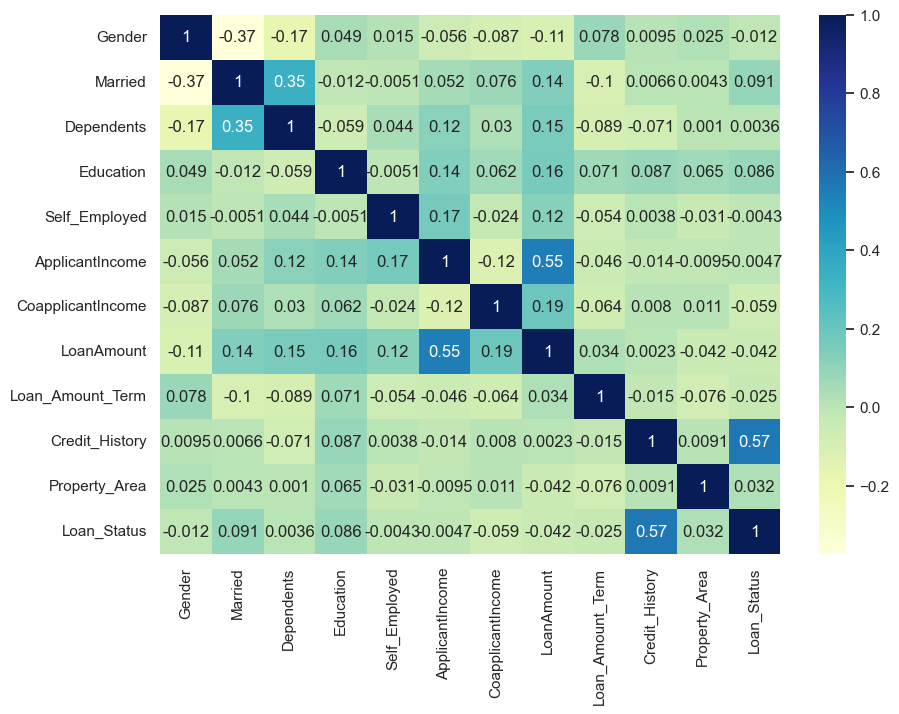

In [340]:
sns.set(rc={'figure.figsize':(10,7)})
dataplot = sns.heatmap(df_info.corr(numeric_only=True), cmap="YlGnBu", annot=True)

[Text(0.5, 1.0, 'Porównanie wykresów dochodów przy podziale na otrzymaną pożyczkę i nieotrzymaną')]

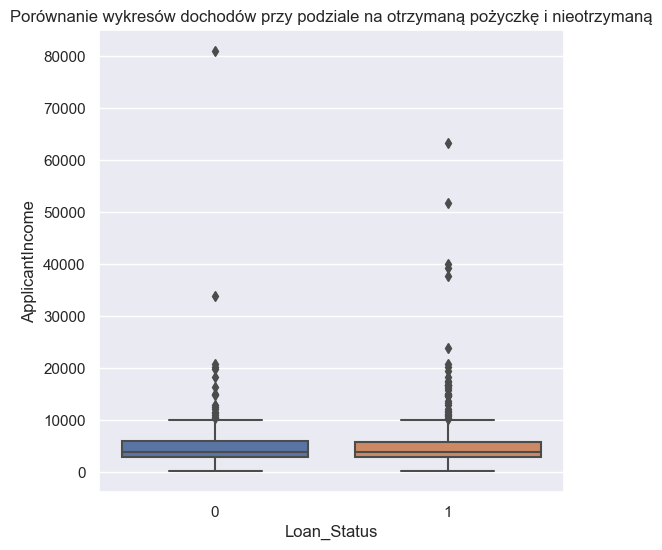

In [341]:
sns.set(rc={'figure.figsize':(6,6)})
sns.boxplot(x='Loan_Status', y='ApplicantIncome', data=df_info).set(title='Porównanie wykresów dochodów przy podziale na otrzymaną pożyczkę i nieotrzymaną')

[Text(0.5, 1.0, 'Porównanie wykresów kwoty pożyczki przy podziale na otrzymaną pożyczkę i nieotrzymaną')]

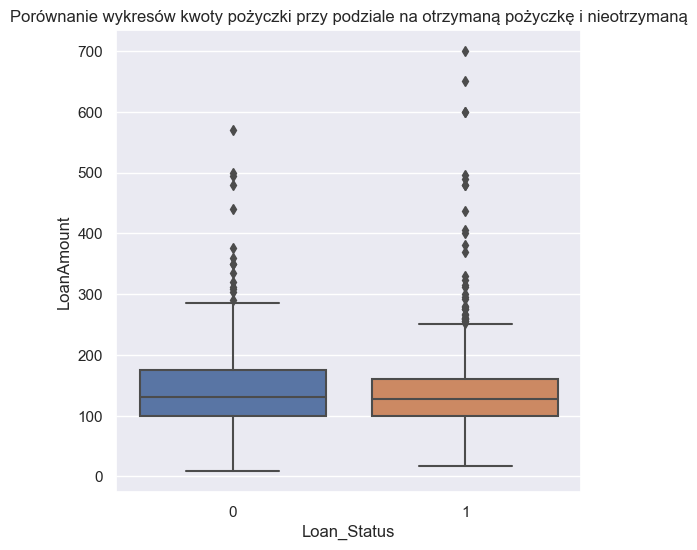

In [342]:
sns.boxplot(x='Loan_Status', y='LoanAmount', data=df_info).set(title='Porównanie wykresów kwoty pożyczki przy podziale na otrzymaną pożyczkę i nieotrzymaną')

<h4>Podział danych na część uczącą i testową oraz normalizacja podzielonych danych</h4>

In [343]:
df_data = df.drop('Loan_Status', axis=1)
df_target = df.Loan_Status
X_train, X_test, y_train, y_test = train_test_split(df_data, df_target, test_size=0.3) #Podział na część uczącą 70% i testową 30%

In [344]:
## Normalizacja danych uczących i testowych
for column in ['Dependents','ApplicantIncome','CoapplicantIncome','LoanAmount','Loan_Amount_Term','Property_Area']:
    X_train[column] = X_train[column] / np.linalg.norm(X_train[column])
    X_test[column] = X_test[column] / np.linalg.norm(X_test[column])

<h3>Metoda k najbliższych sąsiadów (KNN)</h3>

In [345]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_train_pred = knn.predict(X_train)

In [346]:
uczacy_wyniki = pd.crosstab(index=y_train_pred, columns=y_train)
uczacy_wyniki

Loan_Status,N,Y
row_0,,
N,73,8
Y,66,282


In [347]:
accuracy_train = (uczacy_wyniki.iloc[0][0] + uczacy_wyniki.iloc[1][1]) / uczacy_wyniki.to_numpy().sum() #dokładność
accuracy_train

0.8275058275058275

In [348]:
y_test_pred = knn.predict(X_test)
testowy_wyniki = pd.crosstab(index=y_test_pred, columns=y_test) #macierz błędu
testowy_wyniki

Loan_Status,N,Y
row_0,,
N,29,12
Y,24,120


In [349]:
accuracy = (testowy_wyniki.loc['Y']['Y'] + testowy_wyniki.loc['N']['N']) / testowy_wyniki.to_numpy().sum()
sensitivity = testowy_wyniki.loc['Y']['Y'] / testowy_wyniki['Y'].sum()
specificity = testowy_wyniki.loc['N']['N'] / testowy_wyniki['N'].sum()
print(f'''
Dokładność: {accuracy}
Czułość: {sensitivity}
Specyficzność: {specificity}''')


Dokładność: 0.8054054054054054
Czułość: 0.9090909090909091
Specyficzność: 0.5471698113207547


Wybór liczby sąsiadów

In [350]:
wyniki = pd.DataFrame(columns=['sąsiedzi','dokładność','czułość','specyficzność'])
for i in range(1,31):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    y_test_pred = knn.predict(X_test)
    testowy_wyniki = pd.crosstab(index=y_test_pred, columns=y_test) #macierz błędu
    if len(testowy_wyniki) > 1:
        accuracy = (testowy_wyniki.loc['N']['N'] + testowy_wyniki.loc['Y']['Y']) / testowy_wyniki.to_numpy().sum() #dokładność
    else:
        accuracy = testowy_wyniki.loc['Y']['Y'] / testowy_wyniki.to_numpy().sum()
    sensitivity = testowy_wyniki.loc['Y']['Y'] / testowy_wyniki['Y'].sum()
    specificity = testowy_wyniki.loc['N']['N'] / testowy_wyniki['N'].sum()
    wyniki.loc[len(wyniki)] = [i,accuracy,sensitivity,specificity]

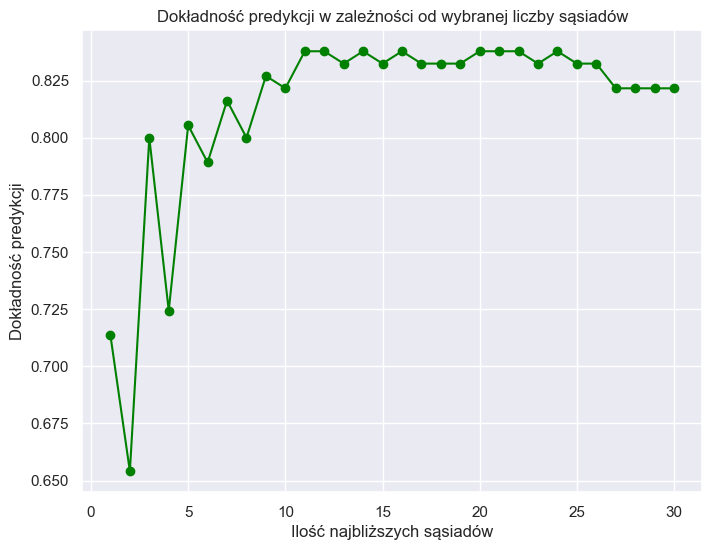

In [351]:
sns.set(rc={'figure.figsize':(8,6)})
wyniki['sąsiedzi'] = wyniki.sąsiedzi.astype(int)
fig = plt.figure()
plt.plot(wyniki.sąsiedzi, wyniki.dokładność, color='green', marker='o')
plt.grid(True)
plt.xlabel('Ilość najbliższych sąsiadów')
plt.ylabel('Dokładność predykcji')
plt.title('Dokładność predykcji w zależności od wybranej liczby sąsiadów')
plt.show()

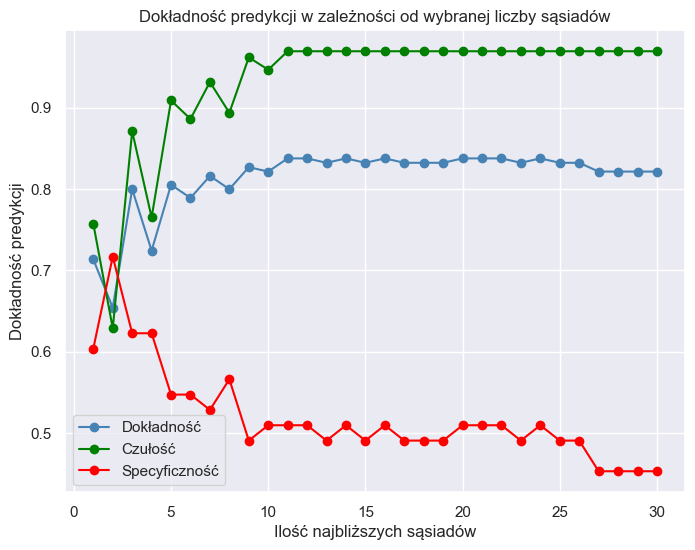

In [352]:
wyniki['sąsiedzi'] = wyniki.sąsiedzi.astype(int)
fig = plt.figure()
plt.plot(wyniki.sąsiedzi, wyniki.dokładność, label='Dokładność', color='steelblue', marker='o')
plt.plot(wyniki.sąsiedzi, wyniki.czułość, label='Czułość', color='green', marker='o')
plt.plot(wyniki.sąsiedzi, wyniki.specyficzność, label='Specyficzność', color='red', marker='o')
plt.grid(True)
plt.legend()
plt.xlabel('Ilość najbliższych sąsiadów')
plt.ylabel('Dokładność predykcji')
plt.title('Dokładność predykcji w zależności od wybranej liczby sąsiadów')
plt.show()

In [353]:
## Wyniki dla danych uczacych dla k=2
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, y_train)
y_train_pred = knn.predict(X_train)
train_wyniki = pd.crosstab(index=y_train_pred, columns=y_train) #macierz błędu
train_wyniki

Loan_Status,N,Y
row_0,,
N,139,56
Y,0,234


In [354]:
## Wyniki dla danych testowych dla k=2
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, y_train)
y_test_pred = knn.predict(X_test)
testowy_wyniki = pd.crosstab(index=y_test_pred, columns=y_test) #macierz błędu
testowy_wyniki

Loan_Status,N,Y
row_0,,
N,38,49
Y,15,83


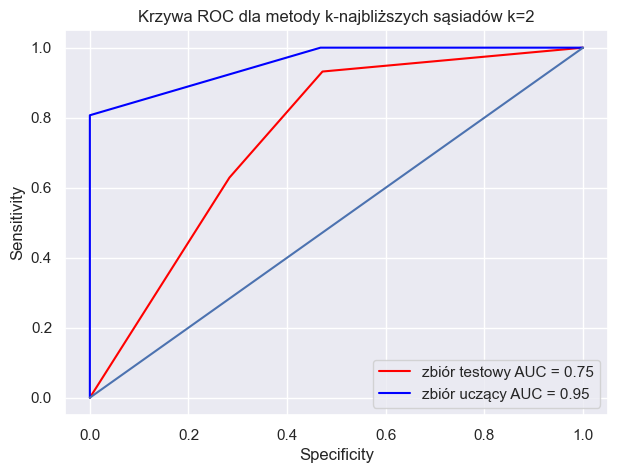

In [355]:
sns.set(rc={'figure.figsize':(7,5)})
y_pred_proba = knn.predict_proba(X_test)[::,1]
y_pred_proba_train = knn.predict_proba(X_train)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba, pos_label='Y')
fpr_t, tpr_t, _ = metrics.roc_curve(y_train,  y_pred_proba_train, pos_label='Y')
auc = metrics.roc_auc_score(y_test, y_pred_proba)
auc_t = metrics.roc_auc_score(y_train,  y_pred_proba_train)
plt.plot(fpr,tpr, color='red', label=f'zbiór testowy AUC = {auc:.2}')
plt.plot(fpr_t,tpr_t, color='blue', label=f'zbiór uczący AUC = {auc_t:.2}')
plt.title('Krzywa ROC dla metody k-najbliższych sąsiadów k=2')
plt.xlabel('Specificity')
plt.ylabel('Sensitivity')
plt.legend()
plt.plot([0,1],[0,1])
plt.show()

<h3>Ważona metoda k najbliższych sąsiadów (KKNN)</h3>

In [356]:
kknn = KNeighborsClassifier(n_neighbors=3, weights='distance')
kknn.fit(X_train, y_train)
y_train_pred = kknn.predict(X_train)

In [357]:
uczacy_wyniki = pd.crosstab(index=y_train_pred, columns=y_train)
uczacy_wyniki

Loan_Status,N,Y
row_0,,
N,139,0
Y,0,290


In [358]:
accuracy = (uczacy_wyniki.loc['Y']['Y'] + uczacy_wyniki.loc['N']['N']) / uczacy_wyniki.to_numpy().sum()
print(f'Dokładność dla zbioru uczącego: {accuracy}')

Dokładność dla zbioru uczącego: 1.0


In [359]:
y_test_pred = kknn.predict(X_test)
testowy_wyniki = pd.crosstab(index=y_test_pred, columns=y_test) #macierz błędu
testowy_wyniki

Loan_Status,N,Y
row_0,,
N,33,19
Y,20,113


In [360]:
accuracy = (testowy_wyniki.loc['Y']['Y'] + testowy_wyniki.loc['N']['N']) / testowy_wyniki.to_numpy().sum()
sensitivity = testowy_wyniki.loc['Y']['Y'] / testowy_wyniki['Y'].sum()
specificity = testowy_wyniki.loc['N']['N'] / testowy_wyniki['N'].sum()
print(f'''
Dokładność: {accuracy}
Czułość: {sensitivity}
Specyficzność: {specificity}''')


Dokładność: 0.7891891891891892
Czułość: 0.8560606060606061
Specyficzność: 0.6226415094339622


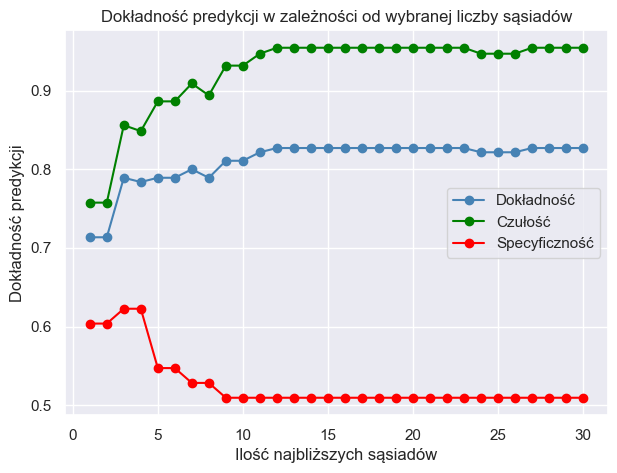

In [361]:
wyniki = pd.DataFrame(columns=['sąsiedzi','dokładność','czułość','specyficzność'])
for i in range(1,31):
    kknn = KNeighborsClassifier(n_neighbors=i, weights='distance')
    kknn.fit(X_train, y_train)
    y_test_pred = kknn.predict(X_test)
    testowy_wyniki = pd.crosstab(index=y_test_pred, columns=y_test) #macierz błędu
    if len(testowy_wyniki) > 1:
        accuracy = (testowy_wyniki.loc['N']['N'] + testowy_wyniki.loc['Y']['Y']) / testowy_wyniki.to_numpy().sum() #dokładność
    else:
        accuracy = testowy_wyniki.loc['Y']['Y'] / testowy_wyniki.to_numpy().sum()
    sensitivity = testowy_wyniki.loc['Y']['Y'] / testowy_wyniki['Y'].sum()
    specificity = testowy_wyniki.loc['N']['N'] / testowy_wyniki['N'].sum()
    wyniki.loc[len(wyniki)] = [i,accuracy,sensitivity,specificity]

wyniki['sąsiedzi'] = wyniki.sąsiedzi.astype(int)
fig = plt.figure()
plt.plot(wyniki.sąsiedzi, wyniki.dokładność, label='Dokładność', color='steelblue', marker='o')
plt.plot(wyniki.sąsiedzi, wyniki.czułość, label='Czułość', color='green', marker='o')
plt.plot(wyniki.sąsiedzi, wyniki.specyficzność, label='Specyficzność', color='red', marker='o')
plt.grid(True)
plt.legend()
plt.xlabel('Ilość najbliższych sąsiadów')
plt.ylabel('Dokładność predykcji')
plt.title('Dokładność predykcji w zależności od wybranej liczby sąsiadów')
plt.show()

In [362]:
## Wyniki dla danych testowych dla k=3
kknn = KNeighborsClassifier(n_neighbors=3, weights='distance')
kknn.fit(X_train, y_train)
y_test_pred = kknn.predict(X_test)
testowy_wyniki = pd.crosstab(index=y_test_pred, columns=y_test) #macierz błędu
testowy_wyniki

Loan_Status,N,Y
row_0,,
N,33,19
Y,20,113


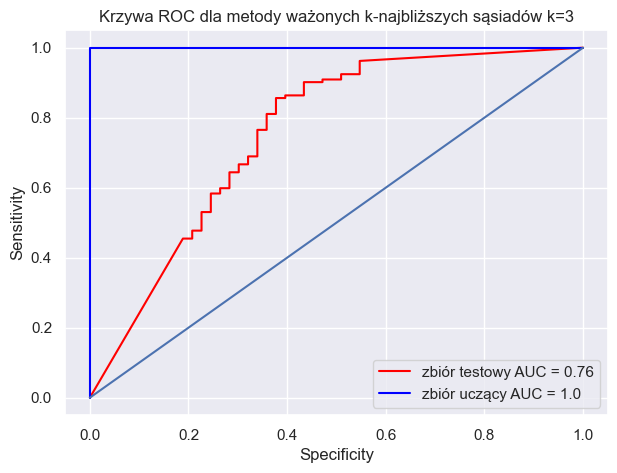

In [363]:
sns.set(rc={'figure.figsize':(7,5)})
y_pred_proba = kknn.predict_proba(X_test)[::,1]
y_pred_proba_train = kknn.predict_proba(X_train)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba, pos_label='Y')
fpr_t, tpr_t, _ = metrics.roc_curve(y_train,  y_pred_proba_train, pos_label='Y')
auc = metrics.roc_auc_score(y_test, y_pred_proba)
auc_t = metrics.roc_auc_score(y_train,  y_pred_proba_train)
plt.plot(fpr,tpr, color='red', label=f'zbiór testowy AUC = {auc:.2}')
plt.plot(fpr_t,tpr_t, color='blue', label=f'zbiór uczący AUC = {auc_t:.2}')
plt.title('Krzywa ROC dla metody ważonych k-najbliższych sąsiadów k=3')
plt.legend()
plt.xlabel('Specificity')
plt.ylabel('Sensitivity')
plt.plot([0,1],[0,1])
plt.show()

<h3>Klasyfikator Bayesa</h3>

In [364]:
df_b = raw_df.copy()
for column in ['ApplicantIncome','CoapplicantIncome','LoanAmount']:
    df_b[column] = pd.cut(df_b[column],
       bins=[-1, df_b[column].quantile(q=0.25),df_b[column].quantile(q=0.5),df_b[column].quantile(q=0.75), df_b[column].max()],
       #duplicates='drop',
       labels=[0,1,2,3])
df_b['Loan_Amount_Term'] = pd.cut(df_b['Loan_Amount_Term'],
                                  bins=[0,360,500],
                                  labels=[0,1])
le = preprocessing.LabelEncoder()
df_b.Property_Area = le.fit_transform(df_b.Property_Area)

for column in df_b:
    df_b[column] = df_b[column].astype('category')

In [365]:
df_data = df_b.drop('Loan_Status', axis=1)
df_target = df_b.Loan_Status
X_train, X_test, y_train, y_test = train_test_split(df_data, df_target, test_size=0.3) #Podział na część uczącą 70% i testową 30%

In [366]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_train_gnb = gnb.predict(X_train)

In [367]:
uczacy_wyniki = pd.crosstab(index=y_train_gnb, columns=y_train)
uczacy_wyniki

Loan_Status,N,Y
row_0,,
N,69,11
Y,72,277


In [368]:
accuracy_train = (uczacy_wyniki.iloc[0][0] + uczacy_wyniki.iloc[1][1]) / uczacy_wyniki.to_numpy().sum() #dokładność
accuracy_train

0.8065268065268065

In [369]:
y_test_gnb = gnb.predict(X_test)
testowy_wyniki = pd.crosstab(index=y_test_gnb, columns=y_test)
testowy_wyniki

Loan_Status,N,Y
row_0,,
N,25,2
Y,26,132


In [370]:
accuracy = (testowy_wyniki.loc['Y']['Y'] + testowy_wyniki.loc['N']['N']) / testowy_wyniki.to_numpy().sum()
sensitivity = testowy_wyniki.loc['Y']['Y'] / testowy_wyniki['Y'].sum()
specificity = testowy_wyniki.loc['N']['N'] / testowy_wyniki['N'].sum()
print(f'''
Dokładność: {accuracy}
Czułość: {sensitivity}
Specyficzność: {specificity}''')


Dokładność: 0.8486486486486486
Czułość: 0.9850746268656716
Specyficzność: 0.49019607843137253


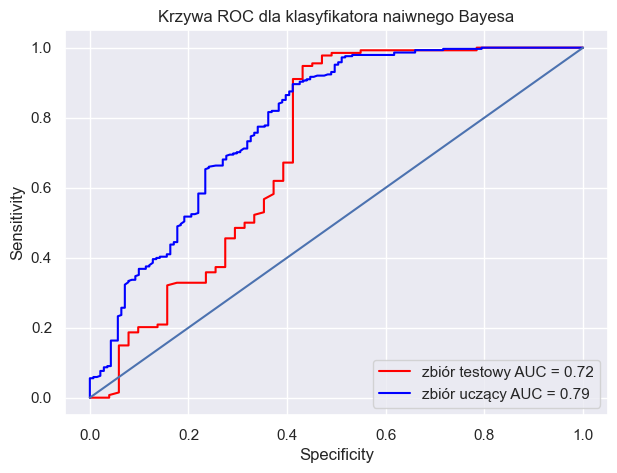

In [371]:
sns.set(rc={'figure.figsize':(7,5)})
y_pred_proba = gnb.predict_proba(X_test)[::,1]
y_pred_proba_train = gnb.predict_proba(X_train)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba, pos_label='Y')
fpr_t, tpr_t, _ = metrics.roc_curve(y_train,  y_pred_proba_train, pos_label='Y')
auc = metrics.roc_auc_score(y_test, y_pred_proba)
auc_t = metrics.roc_auc_score(y_train,  y_pred_proba_train)
plt.plot(fpr,tpr, color='red', label=f'zbiór testowy AUC = {auc:.2}')
plt.plot(fpr_t,tpr_t, color='blue', label=f'zbiór uczący AUC = {auc_t:.2}')
plt.title('Krzywa ROC dla klasyfikatora naiwnego Bayesa')
plt.legend(loc='lower right')
plt.xlabel('Specificity')
plt.ylabel('Sensitivity')
plt.plot([0,1],[0,1])
plt.show()